<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b>
    Before proceeding, install or update your
    <b><a class="divlink" href="https://stenv.readthedocs.io/en/latest/">
    stenv
    </a></b>
     distribution. <b>stenv</b> is the replacement for AstroConda, which is unsupported as of February 2023.
</div>

# Obtaining Pixel Area Maps for ACS Data

## Introduction

***

The optical design of ACS introduces larger geometric distortion than in other *HST* instruments. In the event a user wishes to perform photometry on data that have not been processed by AstroDrizzle, a correction must be applied to account for the different sizes of the pixels on the sky across the field of view.  

A pixel area map (PAM), which is an image where each pixel value describes that pixel's area on the sky relative to the native plate scale, is used for this correction. The distortion corrections applied by both AstroDrizzle and the PAMs include observation-specific corrections (e.g., velocity distortion). For the best results, users are advised to create a PAM for each observation individually.

To transform a distorted FLT/FLC image so that it is suitable for photometry, users must multiply the image by the PAM and divide the result by the exposure time so that the image has units of electrons/second. After this transformation, the information on the [ACS Zeropoints](http://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints) page can be used to convert flux measurements into physical units.

### This tutorial will show you how to...

#### 1. [Construct the Pixel Area Map](#_obtain)

* Use `AstroDrizzle` with ASN files to combine images.

#### 2. [Apply the Pixel Area Map](#_drkdrizzle)

* Identify which dark images to use for your data.
* Use `AstroDrizzle` to combine dark images.

## Imports
***

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
| `os`             | `environ`          | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.environ">link</a>| setting environments |
|`shutil`          | `rmtree`           | <a class="divlink" href="https://docs.python.org/2/library/shutil.html#shutil.rmtree">link</a>| remove directory tree |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`stsci.skypac`       |`pamutils`| <a class="divlink" href="https://stsci-skypac.readthedocs.io/en/latest/pamutils.html">link</a>| construct pixel area map |

In [1]:
import os
import shutil

from astroquery.mast import Observations
from astropy.io import fits
from stsci.skypac import pamutils

from p_module import plot



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


## Download the Data
***

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

#### [GO Proposal 9438](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=9438): "The Origin of the Intergalactic Globular Cluster Population in Abell 1185"

For this example, we will only retreive data associated with the Observation ID **J6ME13QHQ**. Using the python package `astroquery`, we can retreive files from the [MAST](http://archive.stsci.edu) archive.

<div class="alert alert-danger">
<b>MAY CHANGE:</b> The argument "mrp_only" stands for "minimum recommended products only". It currently needs to be set to False, although in the future, False is intended to be set as the default and can be left out.
</div>

In [2]:
obs_table = Observations.query_criteria(proposal_id=9438, obs_id='J6ME13QHQ')

dl_table = Observations.download_products(obs_table['obsid'], 
                                          mrp_only=False, 
                                          productSubGroupDescription=['FLT'])

We'll use the packages `os` and `shutil` to put all of these files in our working directory for convenience and do a little housekeeping.

In [3]:
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
shutil.rmtree('mastDownload')

## File Information
***
The structure of the fits files from ACS may be different depending on what kind of observation was made. For more information, refer to Section 2.2 of the [ACS Data Handbook](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

#### FLT Files (WFC-Specific)

| Ext        | Name             | Type         | Contains                                                 |
|:----------:|------------------|--------------|:---------------------------------------------------------|
|<b>0</b>    | PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                    |
|<b>1</b>    | SCI (Image)      | (ImageHDU)   | WFC2 raw image data.                                     |
|<b>2</b>    | ERR (Error)      | (ImageHDU)   | WFC2 error array.                                        |
|<b>3</b>    | DQ (Data Quality)| (ImageHDU)   | WFC2 data quality array.                                 |
|<b>4</b>    | SCI (Image)      | (ImageHDU)   | WFC1 raw image data.                                     |
|<b>5</b>    | ERR (Error)      | (ImageHDU)   | WFC1 error array.                                        |
|<b>6</b>    | DQ (Data Quality)| (ImageHDU)   | WFC1 data quality array.                                 |
|<b>7-10</b> | D2IMARR          | (ImageHDU)   | Filter-independent CCD pixel-grid distortion corrections.|
|<b>11-14</b>| WCSDVARR         | (ImageHDU)   | Filter-dependent non-polynomial distortion corrections.  |
|<b>15</b>   | WCSCORR          | (ImageHDU)   | History of changes to the WCS solution.                  |

Here, we set our files to variable names below for convenience.

In [4]:
flt_file = 'j6me13qhq_flt.fits'

You can always use `.info()` on an HDUlist for an overview of the structure

In [5]:
with fits.open(flt_file) as hdulist:
    hdulist.info()

Filename: j6me13qhq_flt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     260   ()      
  1  SCI           1 ImageHDU       244   (4096, 2048)   float32   
  2  ERR           1 ImageHDU        53   (4096, 2048)   float32   
  3  DQ            1 ImageHDU        45   (4096, 2048)   int16   
  4  SCI           2 ImageHDU       242   (4096, 2048)   float32   
  5  ERR           2 ImageHDU        53   (4096, 2048)   float32   
  6  DQ            2 ImageHDU        45   (4096, 2048)   int16   
  7  HDRLET        1 HeaderletHDU     18   ()      
  8  HDRLET        2 HeaderletHDU     26   ()      
  9  WCSCORR       1 BinTableHDU     59   14R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   
 10  HDRLET       18 HeaderletHDU     26   ()      
 11  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
 13  D2IMARR       1 

## Construct Pixel Area Map <a id="_obtain"></a>
***

Function input for `pamutils.pam_from_file` is (input_file, extension, output_file). To create a PAM for the first science extension (WFC2) of this observation, we need to specify HDU Extension 1.

In [6]:
pamutils.pam_from_file(flt_file, ext=1, output_pam='j6me13qhq_wfc2_pam.fits')

For full-frame WFC observations, a second PAM for the WFC1 science array (extension 4) can be created as follows:

In [7]:
pamutils.pam_from_file(flt_file, ext=4, output_pam='j6me13qhq_wfc1_pam.fits')

## Apply the Pixel Area Map <a id="_drkdrizzle"></a>
***

Because the pixel area map is an array of flux corrections based on 2d image distortion, you can multiply it by your data element-by-element to produce the corrected image. Here, we present the results.

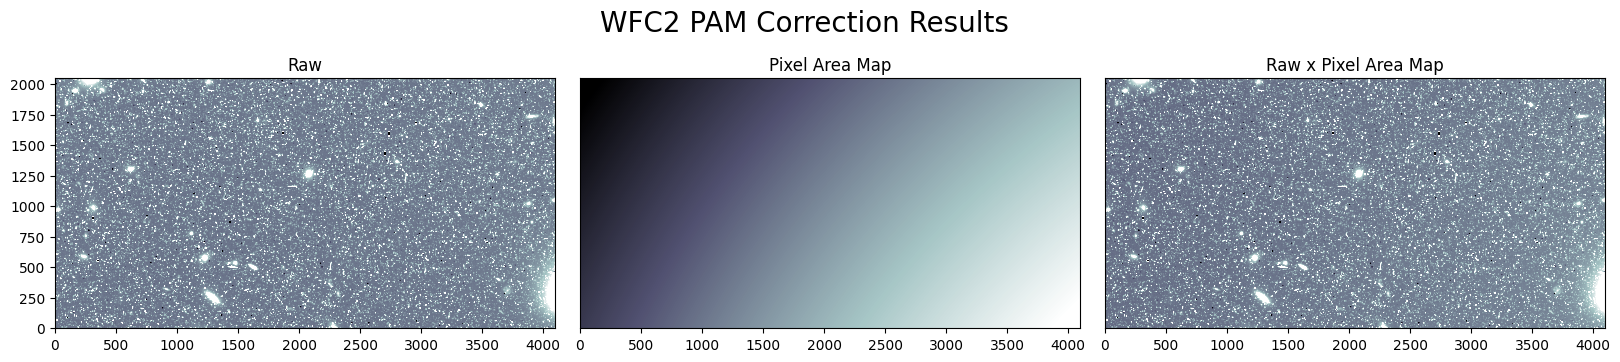

In [8]:
plot.triple_pam_plot(flt_file, 'j6me13qhq_wfc2_pam.fits', 'WFC2 PAM Correction Results')

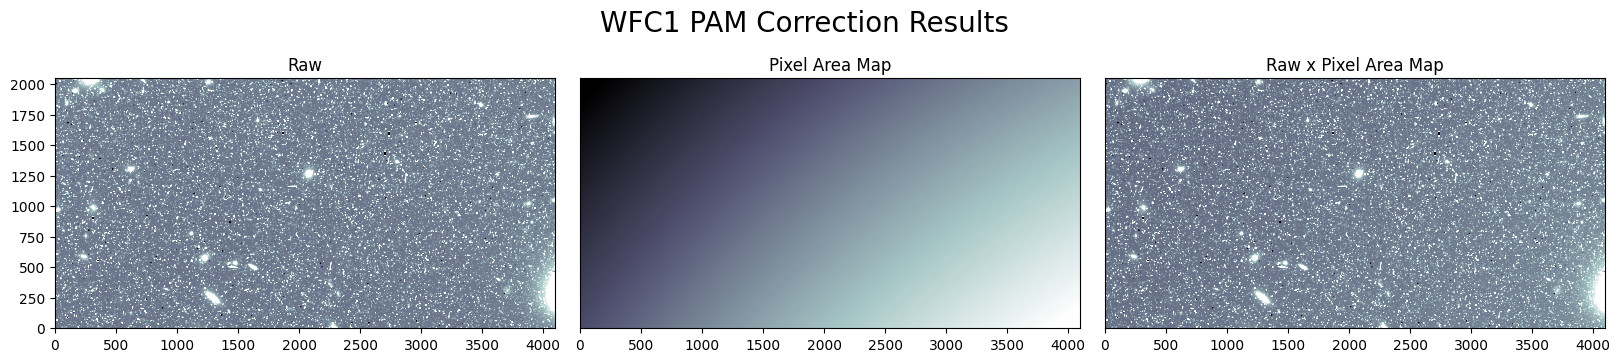

In [9]:
plot.triple_pam_plot(flt_file, 'j6me13qhq_wfc1_pam.fits', 'WFC1 PAM Correction Results')

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf). Geometric Distortion information can be found in [Section 5.6.4](https://hst-docs.stsci.edu/display/ACSIHB/5.6+ACS+Point+Spread+Functions) and [Section 10.4](https://hst-docs.stsci.edu/acsihb/chapter-10-imaging-reference-material/10-4-geometric-distortion-in-acs) of the ACS Instrument Handbook.

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.